# MLA-ViT Comparative Evaluation on CIFAR-100

This notebook evaluates and compares two Vision Transformer variants on the CIFAR-100 dataset:

- **ViT**: A standard Vision Transformer using Multi-Head Attention (MHA).
- **MLA-ViT**: A Vision Transformer using Multi-Head Latent Attention (MLA) with Rotary Positional Embeddings (RoPE) to improve positional encoding efficiency.

Both models are trained from scratch for 300 epochs under identical configurations to ensure a fair comparison. We record training time, inference time, peak memory usage, and accuracy to assess the efficiency and performance of each model. The goal is to determine whether MLA-ViT can maintain comparable accuracy while significantly reducing computational cost and memory requirements.


In [13]:
# Import required libraries.
!pip install torch torchvision matplotlib
import torch
import torch.nn as nn

import torchvision
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from typing import List, Tuple

from models.vit import ViT
from models.mla_vit import MLA_ViT
from models.components import MLAConfig

# Fixed random seed for reproducibility
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # For CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior (reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)





[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Tyo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
# Set experiment-wide hyperparameters
EPOCHS = 300
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [ ]:
# Load CIFAR-10 dataset

# Training dataset with data augmentation:
# - RandomCrop: adds spatial diversity by randomly cropping with padding
# - RandomHorizontalFlip: adds flip-invariance
# - Normalize: standardizes the pixel values (mean=0.5, std=0.5 for each channel)
train_data_set = torchvision.datasets.CIFAR10(
    root='dataset',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(size=(32, 32), padding=4),  # Data augmentation
        torchvision.transforms.RandomHorizontalFlip(),                # Data augmentation
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    download=True
)

# Test dataset without augmentation (only normalized)
test_data_set = torchvision.datasets.CIFAR10(
    root='dataset',
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    download=True
)

# Dataloaders
train_data_load = DataLoader(train_data_set, batch_size=1000, shuffle=True, drop_last=True)
test_data_load = DataLoader(test_data_set, batch_size=1000, shuffle=False, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [16]:

def train_and_evaluate(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_epochs: int = 100,
    learning_rate: float = 0.001
) -> Tuple[List[float], List[float], float, float, float, float]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_accuracies = []
    test_accuracies = []

    torch.cuda.reset_peak_memory_stats(device)
    train_start = time.time()

    for epoch in range(num_epochs):
        model.train()
        correct_train, total_train = 0, 0

        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_test += targets.size(0)
                correct_test += predicted.eq(targets).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accuracy:.2f}% - Val Acc: {test_accuracy:.2f}%")

    train_end = time.time()
    peak_mem_train = torch.cuda.max_memory_allocated(device) / 1024**2

    # Inference benchmark
    torch.cuda.reset_peak_memory_stats(device)
    infer_start = time.time()
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            _ = model(inputs)
    infer_end = time.time()
    peak_mem_infer = torch.cuda.max_memory_allocated(device) / 1024**2

    return train_accuracies, test_accuracies, train_end - train_start, infer_end - infer_start, peak_mem_train, peak_mem_infer



def plot_results_and_stats(results, stats, num_epochs):
    # --- Line plot for accuracy ---
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    for model_name, (train_acc, val_acc) in results.items():
        plt.plot(epochs, train_acc, '--', label=f'{model_name} (Train)')
        plt.plot(epochs, val_acc, '-', label=f'{model_name} (Val)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Bar charts for timing and memory ---
    model_names = list(stats.keys())
    train_times = [stats[m]["Train Time (s)"] for m in model_names]
    infer_times = [stats[m]["Inference Time (s)"] for m in model_names]
    train_mems = [stats[m]["Peak Train Mem (MB)"] for m in model_names]
    infer_mems = [stats[m]["Peak Inference Mem (MB)"] for m in model_names]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0, 0].bar(model_names, train_times, color='skyblue')
    axs[0, 0].set_title('Training Time (s)')
    axs[0, 0].set_ylabel('Seconds')

    axs[0, 1].bar(model_names, infer_times, color='orange')
    axs[0, 1].set_title('Inference Time (s)')
    axs[0, 1].set_ylabel('Seconds')

    axs[1, 0].bar(model_names, train_mems, color='green')
    axs[1, 0].set_title('Peak Training Memory (MB)')
    axs[1, 0].set_ylabel('MB')

    axs[1, 1].bar(model_names, infer_mems, color='red')
    axs[1, 1].set_title('Peak Inference Memory (MB)')
    axs[1, 1].set_ylabel('MB')

    for ax in axs.flat:
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=15)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.suptitle('Timing and Memory Usage per Model')
    plt.tight_layout()
    plt.show()



C:\Users\Tyo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Training ViT-Base
Epoch 1/300 - Train Acc: 22.96% - Val Acc: 31.38%
Epoch 2/300 - Train Acc: 30.01% - Val Acc: 34.28%
Epoch 3/300 - Train Acc: 32.06% - Val Acc: 35.52%
Epoch 4/300 - Train Acc: 33.68% - Val Acc: 37.36%
Epoch 5/300 - Train Acc: 34.82% - Val Acc: 37.38%
Epoch 6/300 - Train Acc: 35.49% - Val Acc: 38.78%
Epoch 7/300 - Train Acc: 36.12% - Val Acc: 39.93%
Epoch 8/300 - Train Acc: 36.04% - Val Acc: 37.75%
Epoch 9/300 - Train Acc: 37.46% - Val Acc: 39.93%
Epoch 10/300 - Train Acc: 38.04% - Val Acc: 40.14%
Epoch 11/300 - Train Acc: 39.12% - Val Acc: 42.85%
Epoch 12/300 - Train Acc: 39.66% - Val Acc: 41.65%
Epoch 13/300 - Train Acc: 39.84% - Val Acc: 43.83%
Epoch 14/300 - Train Acc: 41.20% - Val Acc: 45.67%
Epoch 15/300 - Train Acc: 41.79% - Val Acc: 46.43%
Epoch 16/300 - Train Acc: 41.62% - Val Acc: 45.67%
Epoch 17/300 - Train Acc: 43.18% - Val Acc: 45.72%
Epoch 18/300 - Train Acc: 43.47% - Val Acc: 47.31%
Epoch 19/300 - Train Acc: 44.73% - Val Acc: 47.32%
Epoch 20/300 - Train 

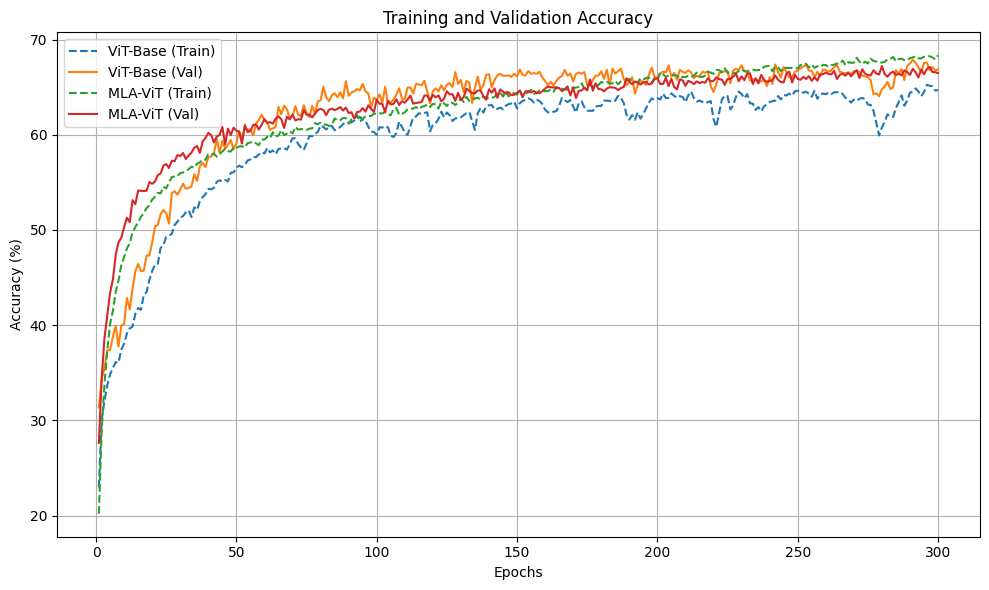

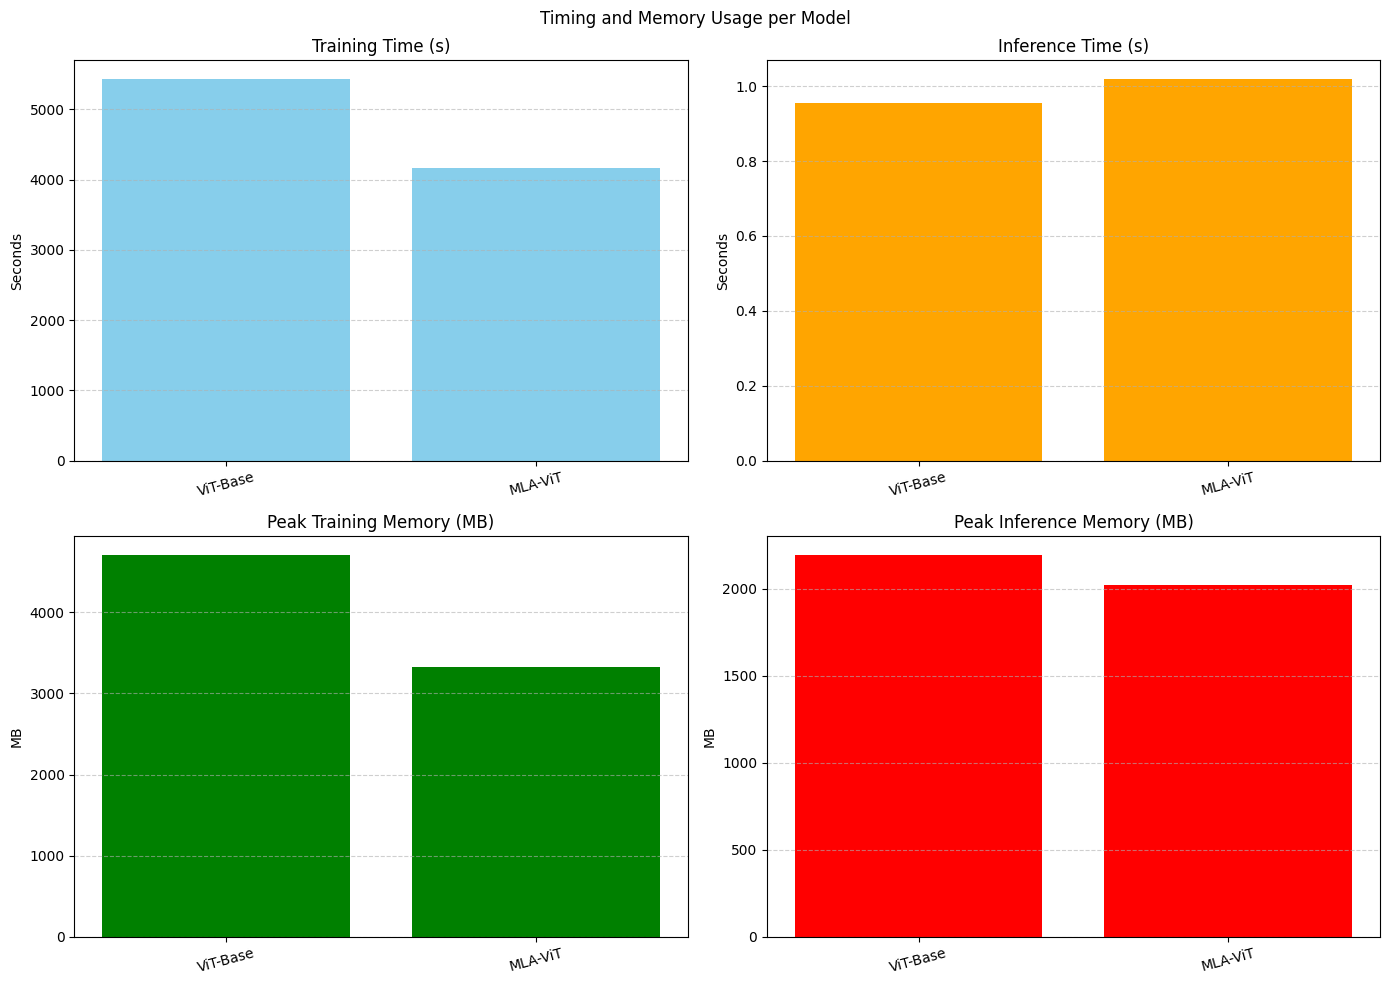


=== Model Stats Summary ===

ViT-Base
  Train Time (s): 5426.14
  Inference Time (s): 0.95
  Peak Train Mem (MB): 4704.31
  Peak Inference Mem (MB): 2193.24

MLA-ViT
  Train Time (s): 4162.56
  Inference Time (s): 1.02
  Peak Train Mem (MB): 3330.36
  Peak Inference Mem (MB): 2022.24


In [17]:

# use Deepseek's MLAConfig
config_deepseek = MLAConfig(
    hidden_size=768,
    num_heads=1,
    max_position_embeddings=1024,
    rope_theta=1280,
    attention_dropout=0, 
    q_lora_rank=1536,
    qk_rope_head_dim=64,
    kv_lora_rank=512,
    v_head_dim=128,
    qk_nope_head_dim=128,
    attention_bias=False,
)

models = {
    "ViT-Base": ViT(image_size=32, patch_size=4, num_classes=10, embed_dim=768, num_heads=1, num_layers=1).to(DEVICE),
    "MLA-ViT": MLA_ViT(config_deepseek, in_channels=3).to(DEVICE),
}

# ==== Run training ====

results = {}
stats = {}

for name, model in models.items():
    print(f"\n{'='*30}\nTraining {name}\n{'='*30}")
    
    train_acc, val_acc, train_time, infer_time, mem_train, mem_infer = train_and_evaluate(
        model=model,
        train_loader=train_data_load,
        test_loader=test_data_load,
        device=DEVICE,
        num_epochs=EPOCHS
    )

    results[name] = (train_acc, val_acc)
    stats[name] = {
        "Train Time (s)": train_time,
        "Inference Time (s)": infer_time,
        "Peak Train Mem (MB)": mem_train,
        "Peak Inference Mem (MB)": mem_infer,
    }

# ==== Output ====

plot_results_and_stats(results, stats,EPOCHS)

print("\n=== Model Stats Summary ===")
for name, info in stats.items():
    print(f"\n{name}")
    for k, v in info.items():
        print(f"  {k}: {v:.2f}")
